In [98]:
import xarray as xr
import os
import xarray as xr
import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import glob
import pandas as pd
from PIL import Image

In [ ]:
datasets = [xr.open_dataset('mcs/' + f) for f in os.listdir('mcs')]
datasets = [ds.swap_dims({'Time': 'XTIME'}) for ds in datasets]
combined_dataset = xr.concat(datasets, dim='XTIME')

In [ ]:
combined_dataset = combined_dataset.rename_dims({'XTIME': 'time'})

In [ ]:
time0 = combined_dataset['time'][0]
for coord in combined_dataset.coords:
    if coord != 'XTIME':
        combined_dataset[coord] = combined_dataset[coord].sel(time = time0)

combined_dataset

<xarray.Dataset>
Dimensions:                (time: 25, south_north: 282, west_east: 405,
                            bottom_top: 37, bottom_top_stag: 38,
                            soil_layers_stag: 4, west_east_stag: 406,
                            south_north_stag: 283, seed_dim_stag: 2)
Coordinates:
    XLAT                   (south_north, west_east) float32 39.85 ... 49.82
    XLONG                  (south_north, west_east) float32 -128.9 ... -107.1
  * XTIME                  (time) datetime64[ns] 2024-08-17T12:00:00 ... 2024...
    XLAT_U                 (south_north, west_east_stag) float32 39.84 ... 49.81
    XLONG_U                (south_north, west_east_stag) float32 -128.9 ... -...
    XLAT_V                 (south_north_stag, west_east) float32 39.83 ... 49.83
    XLONG_V                (south_north_stag, west_east) float32 -128.9 ... -...
Dimensions without coordinates: time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/142)
    Times                  (time) |S19 b'2024-08-17_12:00:00' ... b'2024-08-1...
    LU_INDEX               (time, south_north, west_east) float32 17.0 ... 12.0
    ZNU                    (time, bottom_top) float32 0.9975 0.9925 ... 0.00455
    ZNW                    (time, bottom_top_stag) float32 1.0 0.995 ... 0.0
    ZS                     (time, soil_layers_stag) float32 0.05 0.25 ... 1.5
    DZS                    (time, soil_layers_stag) float32 0.1 0.3 ... 0.6 1.0
    ...                     ...
    C4F                    (time, bottom_top_stag) float32 0.0 5.209 ... 0.0
    PCB                    (time, south_north, west_east) float32 0.0 ... 0.0
    PC                     (time, south_north, west_east) float32 0.0 ... 0.0
    LANDMASK               (time, south_north, west_east) float32 0.0 ... 1.0
    LAKEMASK               (time, south_north, west_east) float32 0.0 ... 0.0
    SST                    (time, south_north, west_east) float32 292.3 ... 2...
Attributes: (12/146)
    TITLE:                            OUTPUT FROM WRF V4.1.3 MODEL
    START_DATE:                      2024-08-17_00:00:00
    SIMULATION_START_DATE:           2024-08-17_00:00:00
    WEST-EAST_GRID_DIMENSION:        406
    SOUTH-NORTH_GRID_DIMENSION:      283
    BOTTOM-TOP_GRID_DIMENSION:       38
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [ ]:
# create shear and cape variables (IN PROGRESS)
temperature = combined_dataset['T']
pressure = combined_dataset['P']
mixing_ratio = combined_dataset['QVAPOR']

vapor_pressure = mpcalc.vapor_pressure(pressure * units.hPa, mixing_ratio * units.kg / units.kg)
dewpoint = mpcalc.dewpoint(vapor_pressure)

# Calculate CAPE (requires pressure and temperature)
cape = mpcalc.most_unstable_cape_cin(pressure.values * units.Pa, temperature.values * units.kelvin, dewpoint)

# Assign CAPE as a new variable in the dataset
combined_dataset['CAPE'] = xr.DataArray(cape, coords=[combined_dataset.time, combined_dataset.south_north, combined_dataset.west_east], dims=['time', 'south_north', 'west_east'])

(array([19651360., 47479751., 11643129.,  4431905.,  4771577.,  4667789.,
         3606659.,  3629390.,  2907001.,  2855689.]),
 array([-20.23245239,   2.39338994,  25.0192318 ,  47.64507294,
         70.2709198 ,  92.89675903, 115.52259827, 138.1484375 ,
        160.77429199, 183.40013123, 206.02597046]),
 <BarContainer object of 10 artists>)

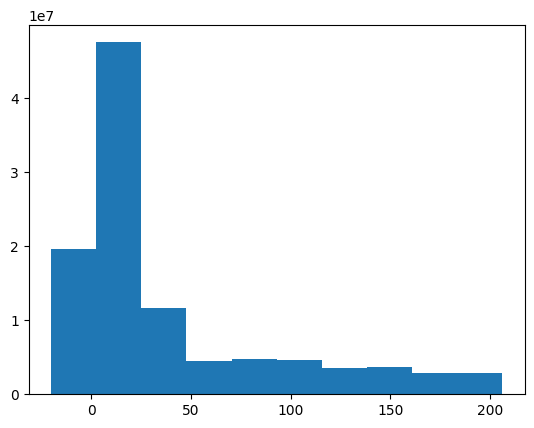

In [114]:
plt.hist(combined_dataset['T'].values.flatten())

In [ ]:
def make_maps(ds, var, title, bottom_top = 0, show = False, save = False, save_loc = None):
    # TODO: make colorbar consistent between frames
    for time in ds['XTIME']:
        if var == 'Wind':
            frame = ds.sel(XTIME = time)['T2'] 
            frameu = ds.sel(XTIME = time)['U10'].thin(10)
            framev = ds.sel(XTIME = time)['V10'].thin(10)
        else:
            frame = ds.sel(XTIME = time)[var]
        if 'bottom_top' in frame.dims:
            frame = frame.sel(bottom_top = bottom_top)
        lat_coord = [name for name in frame.coords if "LAT" in name][0]
        long_coord = [name for name in frame.coords if "LONG" in name][0]

        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
        ax.set_extent([-130, -107, 39, 51])
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
        ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1, edgecolor='black')

        
        if var == 'Wind':
            plt1 = ax.contourf(
                frame[long_coord], frame[lat_coord], frame, cmap='rainbow_r',
                transform=ccrs.PlateCarree())
            plt2 = ax.barbs(
                frameu[long_coord].values, frameu[lat_coord].values, frameu.values, framev.values, transform=ccrs.PlateCarree(), length = 6)
        else:
            plt1 = ax.contourf(
                frame[long_coord], frame[lat_coord], frame, cmap='rainbow_r',
                transform=ccrs.PlateCarree())

        cb = fig.colorbar(plt1, ax=ax, orientation='horizontal', pad=0.05, aspect=30)

        ax.set_title(
            'WRF ' + title,
            fontweight='bold', fontsize=14, loc='left')
        #dt = datetime.utcfromtimestamp(time.values.astype(int) * 1e-9)
        ax.set_title(time.values, fontsize=14, loc='right')
        
        # # Format the gridlines (optional)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, dms=True, x_inline=False,
            y_inline=False, linewidth=1, color='k', linestyle=':')
        gl.xlocator = mticker.FixedLocator([-130, -125, -120, -115, -110])
        gl.ylocator = mticker.FixedLocator([40, 45, 50, 55])
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 16, 'rotation': 20}
        gl.ylabel_style = {'size': 16}

        print(pd.to_datetime(str(time.values)).strftime('%d%H'))
        if save:
            plt.savefig(save_loc + pd.to_datetime(str(time.values)).strftime('%d%H') + '.png')
        if show:
            plt.show()
        
        plt.clf()

#make_maps(combined_dataset, 'Wind', 'Reflectivity (DBZ)', save = True, save_loc='images/Wind/')

In [ ]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}/loop.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0)

In [101]:
# Radar reflectivity (most important), wind, precip, OLR, CAPE (would need to calculate?)
vars_of_interest = ['REFL_10CM', 'PREC_ACC_C', 'PREC_ACC_NC', 'OLR', 'Wind'] # And 'Shear' once shear and cape created as variables 
titles = vars_of_interest
for var, title in zip(vars_of_interest, titles):
    print(var)
    make_maps(combined_dataset, var, title, save = True, save_loc = 'images/' + var + '/')
    make_gif('images/'+ var)




REFL_10CM
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1800
1801
1802
1803
1804
1805
1806
1807


C:\Users\miles\AppData\Local\Temp\ipykernel_2640\443029490.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(16, 12))


1808
1809
1810
1811
1812
PREC_ACC_C
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
PREC_ACC_NC
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
OLR
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
Wind
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812


<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>